In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
import cartopy.crs as ccrs

%matplotlib inline

## Preprocess

In [ ]:
# Manually set PROJ_LIB environment if you're having issues with pyproj module in Anaconda
import os
os.environ['PROJ_LIB'] = r"C:\Users\mark.nguyen\AppData\Local\Continuum\anaconda3\envs\ds\Library\share"

In [2]:
# Define constants

STORETOLERANCE = 5

In [6]:
# Read in dmas
dmas_gdf = gpd.read_file('nielsengeo.json')
dmas_gdf = (dmas_gdf.drop(columns='name').
                   rename(columns=dict(dma='dma_code',dma1='dma_name')))

# Load Performance metrics for each dma
perf_df = pd.read_csv('performance_by_dma.csv')

# Merge performance data with dmas_df
dmas_gdf = (dmas_gdf.merge(perf_df,on='dma_code',how='left').
           drop(columns='dma').
           fillna(value=0))

# Set default projection
dmas_gdf.crs = dict(init='epsg:4326')

In [13]:
# Set Map projection to Albers Equal Area
# projection = ccrs.AlbersEqualArea(central_latitude=39.5,central_longitude=-98.35).proj4_params

# Set Map projection to US Atlas National Equal Area
projection = dict(init='epsg:2163')

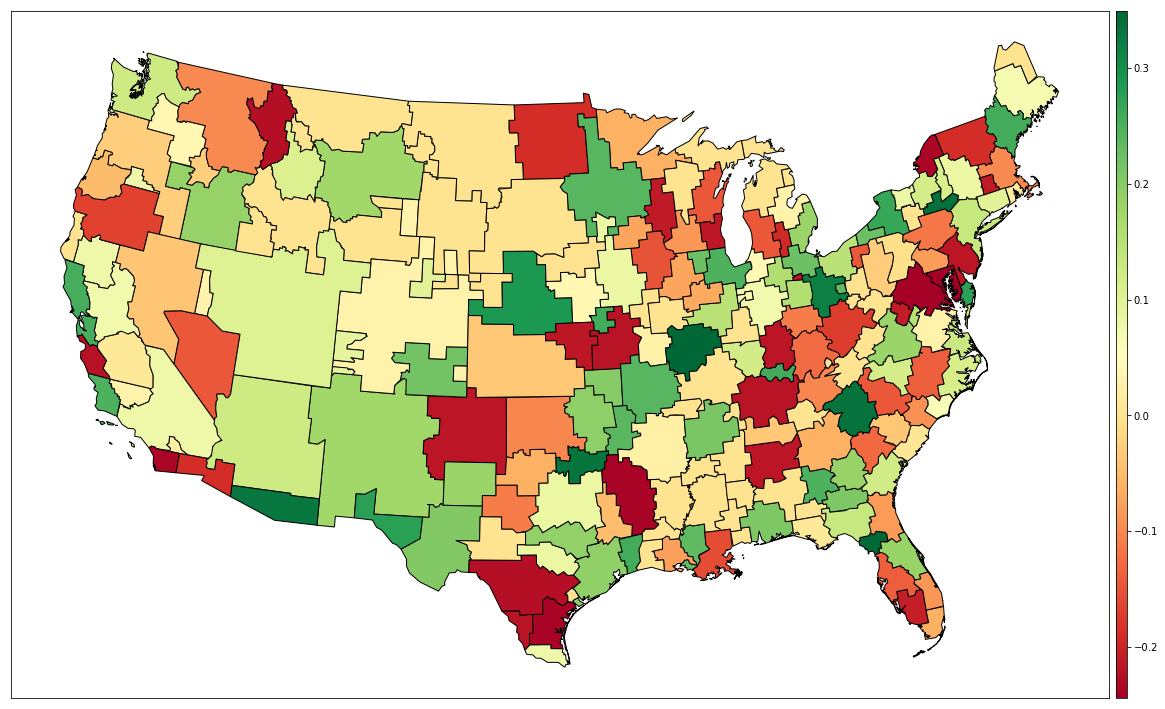

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(20,15))

plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right',size='1%', pad=0.1)

dmas_gdf.to_crs(projection,inplace=True)
dmas_gdf.plot(column='sales_growth',
              ax=ax,
              edgecolor='black',
              legend=True,
              cax=cax,cmap='RdYlGn');

## Observations

Geopandas does not allow to set custom color scales. The next step is draw multiple layers of DMA regions that fall into a custom color category

In [16]:
def get_perf_color(val,store_cnt,store_tolerance=5):
    """
    Returns the performance color given the value. Returns the default color 'grey' if store_cnt == 0 or store_cnt < store_tolerance
    TODO: Add support for custom color scales as input to this function
    
    Parameters:
        val (number): input value
        store_cnt (number): store count of the DMA associated with the given value
        store_tolerance (number): defines minimum number of stores a DMA should have in order to display a color
    
    Returns:
    
    (str) Color in hex format
    """
    
    assert store_cnt >= 0, "store count must not be negative!"
    assert store_tolerance >= 1, "store tolerance must be at least 1!"
    
    # Define color scales here
    high_color = '#17800b'
    normal_color = '#2fff13'
    caution_color = '#ff8521'
    danger_color = '#ff0a2b'
    default_color = 'grey'
    
    high = 0.25
    normal = 0
    caution = -0.10
    
    # Only color sizable DMA's defined by store_tolerance
    if store_cnt > store_tolerance:
    
        if val > high:
            return high_color
        elif val > normal:
            return normal_color
        elif val > caution:
            return caution_color
        else:
            return danger_color
    else:
        return default_color

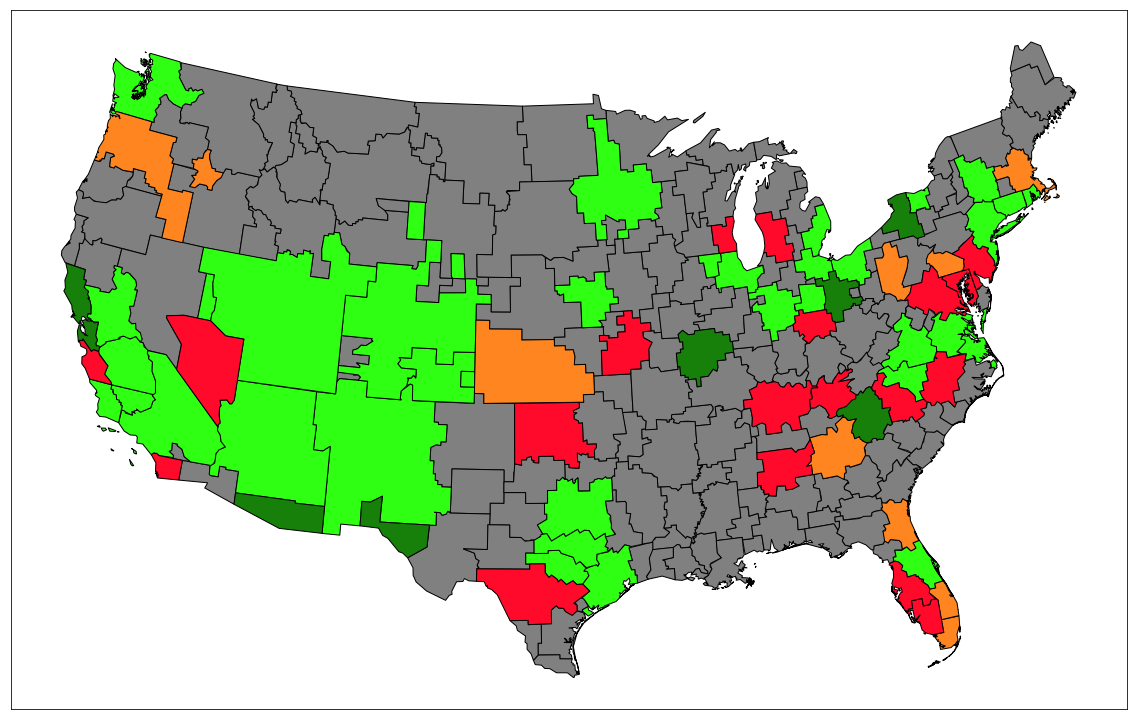

In [17]:
dmas_gdf['perf_color'] =  dmas_gdf.apply(lambda s: get_perf_color(s['sales_growth'],s['store_count'],STORETOLERANCE), axis=1)

fig, ax = plt.subplots(figsize=(20,15))
ax.set_aspect('equal')

plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False
)

for color in dmas_gdf['perf_color'].unique():
    col_gdf = dmas_gdf.query(f'perf_color == "{color}"')
    col_gdf.plot(ax=ax,color=color,edgecolor='black')